In [294]:
# Import necessary modules and functions

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# For unix timestamps
from datetime import datetime

In [295]:
# Import the 'KS_train_data.csv' file into a Pandas DataFrame
df = pd.read_csv('KS_train_data.csv',delimiter=',')

In [296]:
# The imported dataframe's column headers
cols = df.columns
print(cols)

# The removed columns in the testdata
notInTestCols = ['funded', 'pledged', 'usd_pledged', 'converted_pledged_amount', 'backers_count']

# The columns containing unix timestamps
unixcols = ['created_at','deadline', 'launched_at']

# Find missing values
df[cols].isnull().sum()

Index(['project_id', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'currency',
       'deadline', 'fx_rate', 'goal', 'launched_at', 'name', 'pledged',
       'staff_pick', 'usd_pledged', 'location', 'funded', 'subcategory',
       'project_url', 'reward_url'],
      dtype='object')


project_id                  0
backers_count               0
blurb                       2
category                    0
converted_pledged_amount    0
country                     3
created_at                  0
currency                    0
deadline                    0
fx_rate                     0
goal                        0
launched_at                 0
name                        1
pledged                     0
staff_pick                  0
usd_pledged                 0
location                    0
funded                      0
subcategory                 0
project_url                 0
reward_url                  0
dtype: int64

In [297]:
# Print the dataframe's first 5 rows
df.head()

,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,launched_at,name,pledged,staff_pick,usd_pledged,location,funded,subcategory,project_url,reward_url
0,KS_000000,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.0,...,1332969260,Elsewhere Studios artist-in-residency program!,3596.0,False,3596.0,"Paonia, CO",True,mixed media,https://www.kickstarter.com/projects/hilaryeme...,https://www.kickstarter.com/projects/hilaryeme...
1,KS_000001,82,1000 Artists is a public art-making installati...,art,4586,US,1330926084,USD,1336440145,1.0,...,1332984145,1000 Artists: Presidential Inauguration 2013,4586.0,False,4586.0,"Washington, DC",True,public art,https://www.kickstarter.com/projects/17146650/...,https://www.kickstarter.com/projects/17146650/...
2,KS_000002,21,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",art,5217,US,1332382894,USD,1338175739,1.0,...,1332991739,MyPhoneHenge,5217.0,False,5217.0,"Frisco, TX",True,sculpture,https://www.kickstarter.com/projects/belveal/m...,https://www.kickstarter.com/projects/belveal/m...
3,KS_000003,37,A film exploring the role and value of art edu...,art,7160,GB,1332342451,USD,1334806096,1.0,...,1332991696,Walk-Through,7160.0,False,7160.0,"Glasgow, UK",True,art,https://www.kickstarter.com/projects/107813091...,https://www.kickstarter.com/projects/107813091...
4,KS_000004,153,We need to build a kitchen for Habitable Space...,art,15445,US,1328562617,USD,1335584240,1.0,...,1332992240,A kitchen for Habitable Spaces,15445.0,False,15445.0,"Kingsbury, TX",True,public art,https://www.kickstarter.com/projects/104409276...,https://www.kickstarter.com/projects/104409276...


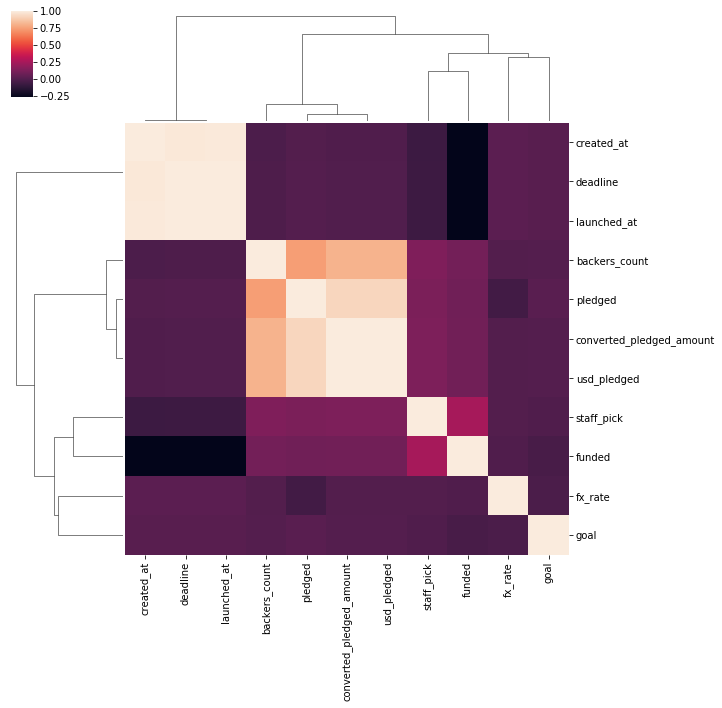

In [298]:
sns.clustermap(df.corr());

In [299]:
### This part fixes the countries, keep in mind that we need this before running the continent code

# Fill in the missing country values in df
df.loc[df['country'].isnull(),'country']
df['country'] = df['country'].fillna('?');

# Make extra country_code column, where the countries are represented by a numeric value
df.country = pd.Categorical(df.country)
df['country_code'] = df.country.cat.codes

In [324]:
### This part creates the continents codes, run the part for the countries first before running this!

# Africa
AF = ['AO','BF','BI','BJ','BW','CD','CF','CG','CI','CM','CV','DJ','DZ','EG','EH','ER','ET','GA','GH','GM','GN','GQ','GW','KE','KM','LR','LS','LY','MA','MG','ML','MR','MU','MW','MZ','NA','NE','NG','RE','RW','SC','SD','SH','SL','SN','SO','SS','ST','SZ','TD','TG','TN','TZ','UG','YT','ZA','ZM','ZW']

# Antarctica
AN = ['AQ','BV','GS','HM','TF']

# Asia
AS = ['AE','AF','AM','AP','AZ','BD','BH','BN','BT','CC','CN','CX','CY','GE','HK','ID','IL','IN','IO','IQ','IR','JO','JP','KG','KH','KP','KR','KW','KZ','LA','LB','LK','MM','MN','MO','MV','MY','NP','OM','PH','PK','PS','QA','SA','SG','SY','TH','TJ','TL','TM','TW','UZ','VN','YE']

# Europe
EU = ['AD','AL','AT','AX','BA','BE','BG','BY','CH','CZ','DE','DK','EE','ES','EU','FI','FO','FR','FX','GB','GG','GI','GR','HR','HU','IE','IM','IS','IT','JE','LI','LT','LU','LV','MC','MD','ME','MK','MT','NL','NO','PL','PT','RO','RS','RU','SE','SI','SJ','SK','SM','TR','UA','VA','XK']

# North America
NA = ['AG','AI','AN','AW','BB','BL','BM','BS','BZ','CA','CR','CU','DM','DO','GD','GL','GP','GT','HN','HT','JM','KN','KY','LC','MF','MQ','MS','MX','NI','PA','PM','PR','SV','TC','TT','US','VC','VG','VI']

# Oceania
OC = ['AS','AU','CK','FJ','FM','GU','KI','MH','MP','NC','NF','NR','NU','NZ','PF','PG','PN','PW','SB','TK','TO','TV','UM','VU','WF','WS']

# South America
SA = ['AR','AW','BO','BR','BQ','CL','CO','CW', 'EC','FK','GF','GY','PE','PY','SR','SX','UY','VE']

# Unknown Country, Unknown Continent: in case you did for got to run the country code, nan is also here.
UN = ['?',np.nan]

def GetConti(country):
    if country in UN:
        return "?"
    elif country in AF:
        return "AF"
    elif country in AN:
        return "AN"
    elif country in AS:
        return "AS"
    elif country in EU:
        return "EU"
    elif country in NA:
        return "NA"
    elif country in OC:
        return "OC"
    elif country in SA:
        return "SA"
    else:
        return "other"

df['continent_code'] = df['country'].apply(lambda x: GetConti(x))

# Remove unknown continents/country or other
df = df[df.continent_code != '?']
df = df[df.continent_code != 'other']

# Make the continent_code column, where the continents are represented by a numeric value
df.continent_code = pd.Categorical(df.continent_code)
df['continent_code'] = df.continent_code.cat.codes

In [325]:
# 5 countries are unknown
#df['continent_code'].isnull().sum()
#df.loc[df['continent_code'].isnull(),'country']

In [326]:
# Counts the numbers of countries in a continent
df.groupby('continent_code').count()

,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,usd_pledged,location,funded,subcategory,project_url,reward_url,country_code,date_created_at,date_deadline,date_launched_at
continent_code,,,,,,,,,,,,,,,,,,,,,
0,370,370,370,370,370,370,370,370,370,370,...,370,370,370,370,370,370,370,370,370,370
1,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
2,1424,1424,1424,1424,1424,1424,1424,1424,1424,1424,...,1424,1424,1424,1424,1424,1424,1424,1424,1424,1424
3,13969,13969,13968,13969,13969,13969,13969,13969,13969,13969,...,13969,13969,13969,13969,13969,13969,13969,13969,13969,13969
4,81000,81000,80999,81000,81000,81000,81000,81000,81000,81000,...,81000,81000,81000,81000,81000,81000,81000,81000,81000,81000
5,2192,2192,2192,2192,2192,2192,2192,2192,2192,2192,...,2192,2192,2192,2192,2192,2192,2192,2192,2192,2192
6,304,304,304,304,304,304,304,304,304,304,...,304,304,304,304,304,304,304,304,304,304


In [303]:
# Investigating '?' countries

#df['continent_code'].isnull()
#df.loc[df['continent_code'].isnull(),'location']
#df.blurb[862]
#843      ?
#847      ?
#851      ?
#852      ?
#853      ?
#856      ?
#858      ?
#862      ?

In [304]:
### UNIX TIMESTAMPS
ts = int("1284101485")
# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2010-09-10 06:51:25


In [305]:
### UNIX TIMESTAMPS
# unixcols contains unix timestamps (made at the beginning of the file)

df['date_created_at'] = pd.to_datetime(df[unixcols[0]],unit='s')
#df['time_created_at'] =

df['date_deadline'] = pd.to_datetime(df[unixcols[1]],unit='s')
#df['time_deadline'] =

df['date_launched_at'] = pd.to_datetime(df[unixcols[2]],unit='s')
#df['time_launched_at'] =

#timestamp = datetime.datetime.fromtimestamp(1500000000)
#print(timestamp)
#print(timestamp.strftime('%Y-%m-%d %H:%M:%S'))
#datetime.datetime.fromtimestamp(df.deadline[1]).strftime('%Y-%m-%d %H:%M:%S')

In [306]:
#df['date'] = pd.to_datetime(df['deadline'],unit='s')
df.head()

,project_id,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,...,location,funded,subcategory,project_url,reward_url,country_code,continent_code,date_created_at,date_deadline,date_launched_at
0,KS_000000,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.0,...,"Paonia, CO",True,mixed media,https://www.kickstarter.com/projects/hilaryeme...,https://www.kickstarter.com/projects/hilaryeme...,162,NA,2012-01-07 23:55:05,2012-04-19 20:16:00,2012-03-28 21:14:20
1,KS_000001,82,1000 Artists is a public art-making installati...,art,4586,US,1330926084,USD,1336440145,1.0,...,"Washington, DC",True,public art,https://www.kickstarter.com/projects/17146650/...,https://www.kickstarter.com/projects/17146650/...,162,NA,2012-03-05 05:41:24,2012-05-08 01:22:25,2012-03-29 01:22:25
2,KS_000002,21,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",art,5217,US,1332382894,USD,1338175739,1.0,...,"Frisco, TX",True,sculpture,https://www.kickstarter.com/projects/belveal/m...,https://www.kickstarter.com/projects/belveal/m...,162,NA,2012-03-22 02:21:34,2012-05-28 03:28:59,2012-03-29 03:28:59
3,KS_000003,37,A film exploring the role and value of art edu...,art,7160,GB,1332342451,USD,1334806096,1.0,...,"Glasgow, UK",True,art,https://www.kickstarter.com/projects/107813091...,https://www.kickstarter.com/projects/107813091...,56,EU,2012-03-21 15:07:31,2012-04-19 03:28:16,2012-03-29 03:28:16
4,KS_000004,153,We need to build a kitchen for Habitable Space...,art,15445,US,1328562617,USD,1335584240,1.0,...,"Kingsbury, TX",True,public art,https://www.kickstarter.com/projects/104409276...,https://www.kickstarter.com/projects/104409276...,162,NA,2012-02-06 21:10:17,2012-04-28 03:37:20,2012-03-29 03:37:20


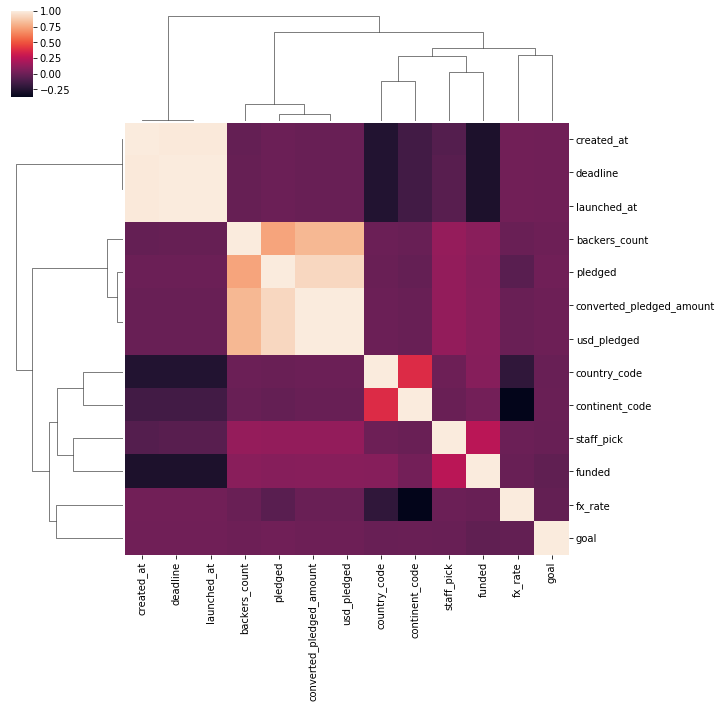

In [327]:
sns.clustermap(df.corr());